# ML Практическая работа 2
## Мурадян Денис

### logistic regression and svm

*Примечание:* загрузка датасета
> Чтобы не забивать ноутбук вставками из прошлого дз с предобработкой данных - выгрузим уже отчищенный датасет в отдельный файл, опубликуем его в личных датасетах `kaggle` и импортируем сюда.

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("denismuradyan/cleaned-dataset-of-used-cars")

print("Path to dataset files:", path)

Mounting files to /kaggle/input/cleaned-dataset-of-used-cars...
Path to dataset files: /kaggle/input/cleaned-dataset-of-used-cars


In [2]:
import pandas as pd

df = pd.read_csv(f"{path}/cleaned_data_used_cars.csv")
df.head()

,id,price,year,condition,cylinders,odometer,title_status,description,posting_date,fuel_electric,...,transmission_manual,transmission_other,drive_fwd,drive_rwd,state_freq,region_freq,type_freq,paint_color_freq,te_model_oof,te_manufacturer_oof
0,7316356412,15000,2013,3,6,128000.0,0.0,2013 F-150 XLT V6 4 Door. Good condition. Leve...,2021-05-03 19:02:03,False,...,False,False,False,True,0.012329,0.000328,0.105321,0.209170,20228.583361,20136.757536
1,7316343444,27990,2012,2,8,68696.0,0.0,Carvana is the safer way to buy a car During t...,2021-05-03 18:41:25,False,...,False,True,False,False,0.012329,0.000328,0.126077,0.209170,24936.745669,24228.390664
2,7316304717,34590,2016,2,6,29499.0,0.0,Carvana is the safer way to buy a car During t...,2021-05-03 17:41:33,False,...,False,True,False,False,0.012329,0.000328,0.126077,0.148408,25099.600519,19914.615212
3,7316285779,35000,2019,3,6,43000.0,0.0,Selling my 2019 Toyota Tacoma TRD Off Road Dou...,2021-05-03 17:12:59,False,...,False,False,False,False,0.012329,0.000328,0.105321,0.095670,21119.239527,16356.129063
4,7316257769,29990,2016,2,6,17302.0,0.0,Carvana is the safer way to buy a car During t...,2021-05-03 16:31:14,False,...,False,True,False,False,0.012329,0.000328,0.126077,0.105005,22501.109375,20019.638000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173973 entries, 0 to 173972
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   173973 non-null  int64  
 1   price                173973 non-null  int64  
 2   year                 173973 non-null  int64  
 3   condition            173973 non-null  int64  
 4   cylinders            173973 non-null  int64  
 5   odometer             173973 non-null  float64
 6   title_status         173566 non-null  float64
 7   description          173972 non-null  object 
 8   posting_date         173973 non-null  object 
 9   fuel_electric        173973 non-null  bool   
 10  fuel_gas             173973 non-null  bool   
 11  fuel_hybrid          173973 non-null  bool   
 12  fuel_other           173973 non-null  bool   
 13  transmission_manual  173973 non-null  bool   
 14  transmission_other   173973 non-null  bool   
 15  drive_fwd        

## Цели и задачи

**Цель работы:**  
В данной работе мы будем применять *логистическую регрессию* и *методы опорных векторов (SVM)* — для задачи классификации автомобилей по цене.  
Наша задача заключается в том, чтобы на основе характеристик автомобиля (год выпуска, пробег, состояние, технические параметры и др.) предсказать, является ли машина «дорогой» или «недорогой».  

**Основные задачи практической работы:**  
1. Провести предварительный анализ данных, подготовить признаки для обучения.  
2. Проверить наличие дисбаланса классов, а также исследовать корреляции между признаками и целевой переменной.  
3. Применить логистическую регрессию для классификации, подобрать гиперпараметры и оценить качество модели.  
4. Применить метод опорных векторов (SVM), обосновать выбор ядра, подобрать гиперпараметры и оценить качество модели.  
5. Сравнить результаты алгоритмов по метрикам **Accuracy** и **F1-score** и сделать выводы.  

**Дополнительно:**  
В качестве расширенного задания будут протестированы различные ядра для SVM (линейное, радиально-базисное и полиномиальное) с последующим сравнением их качества.  


## Подготовка данных

Для построения моделей важно корректно подготовить данные. На этом этапе мы выполним следующие шаги:

1. **Удаление ненужных признаков.**  
   - `id` — технический идентификатор, не несущий информации.  
   - `description` — текстовое поле с описанием, которое мы хотели преобразовывать в векторную embedding форму, пока исключим из анализа.  
   - `posting_date` — дата публикации, не связана напрямую с ценой.

2. **Обработка признаков.**  
   - Приведём булевы признаки (`fuel_*`, `transmission_*`, `drive_*`) к целочисленному формату (0/1).  

3. **Формирование целевой переменной.**  
   Мы решаем задачу **бинарной классификации**:  
   - 1 — автомобиль дороже медианной цены,  
   - 0 — автомобиль дешевле либо равен медианной цене.  
   Это позволит сбалансировать классы и корректно применять метрику F1.

4. **Проверка дисбаланса классов.**  
   Посмотрим распределение целевой переменной, чтобы понять, нужно ли использовать `class_weight='balanced'`.

   На этом шаге оценим баланс целевой переменной:
- абсолютные и относительные доли классов;
- **imbalance ratio (IR)** = доля большинства / доля меньшинства;
- «наивная» baseline-точность — если всегда предсказывать **большинство**.

Также построим визуализации распределения классов (bar chart и pie chart) для наглядности.

6. Масштабирование признаков и разбиение на выборки

Для обучения моделей разобьём данные на **train/validation/test** в соотношении 70/15/15.  
Разбиение сделаем со стратификацией по целевой переменной, чтобы в каждой выборке сохранялось равное соотношение классов.  

Также выполним **масштабирование числовых признаков** с помощью `StandardScaler`:  
- обучим скейлер на тренировочной выборке,  
- применим его к train/valid/test.  


> доплнительно обработаем пропуски в `title_status` - которые мы оставили в ходе прошлой работе, так как отсутсвие описание статус - является и отображает его отсутвие. Сейчас, чтобы не мешалось просто удалим строки с пропусками, блоаги их немного, 407 - по сравнению с размером датасета это несущественно
> Так же после формирования таргет-переменной, удалим признак price - чтобы он не учавствовал в обучающей выборке

In [4]:
# удалим ненужные признаки
df = df.drop(columns=['id', 'description', 'posting_date'])

# приведем булевы признаки к int (0/1)
bool_cols = df.select_dtypes(include=['bool']).columns
df[bool_cols] = df[bool_cols].astype(int)

In [5]:
df = df.dropna(subset=['title_status'])
print("Количество пропусков в каждом признаке:")
print(df.isna().sum())

Количество пропусков в каждом признаке:
price                  0
year                   0
condition              0
cylinders              0
odometer               0
title_status           0
fuel_electric          0
fuel_gas               0
fuel_hybrid            0
fuel_other             0
transmission_manual    0
transmission_other     0
drive_fwd              0
drive_rwd              0
state_freq             0
region_freq            0
type_freq              0
paint_color_freq       0
te_model_oof           0
te_manufacturer_oof    0
dtype: int64


In [6]:
# формируем целевую переменную
median_price = df['price'].median()
df['target'] = (df['price'] > median_price).astype(int)

# удалим исходную цену, чтобы она не участвовала в обучении как признак
df = df.drop(columns=['price'])


Распределение целевой переменной:
target
0    0.500536
1    0.499464
Name: proportion, dtype: float64
Распределение классов
Всего объектов: 173566
Класс 0: 86876 (0.501)
Класс 1: 86690 (0.499)
Imbalance Ratio (IR): 1.002
Baseline Accuracy (всегда предсказывать класс 0): 0.501


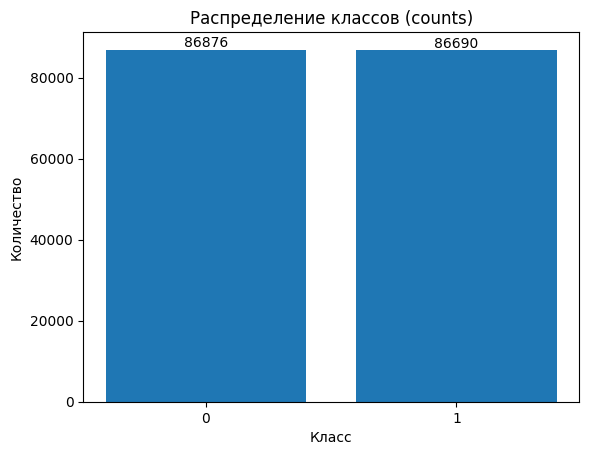

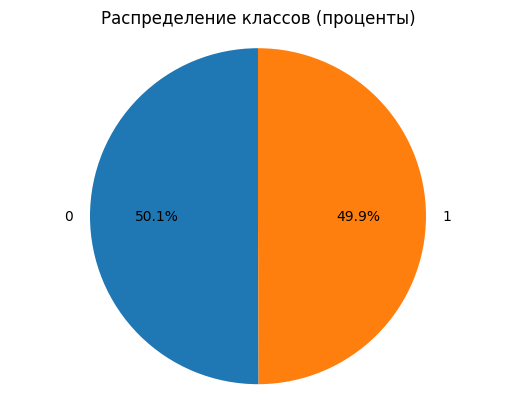

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# проверим баланс классов
print("\nРаспределение целевой переменной:")
print(df['target'].value_counts(normalize=True))

vc_abs = df['target'].value_counts().sort_index()           # 0,1 по порядку
vc_rel = df['target'].value_counts(normalize=True).sort_index()

n_total = int(vc_abs.sum())
n0, n1 = int(vc_abs.get(0, 0)), int(vc_abs.get(1, 0))
p0, p1 = float(vc_rel.get(0, 0.0)), float(vc_rel.get(1, 0.0))

majority_class = 0 if p0 >= p1 else 1
majority_share = max(p0, p1)
minority_share = min(p0, p1)
imbalance_ratio = (majority_share / minority_share) if minority_share > 0 else np.inf
baseline_acc = majority_share

print("Распределение классов")
print(f"Всего объектов: {n_total}")
print(f"Класс 0: {n0} ({p0:.3f})")
print(f"Класс 1: {n1} ({p1:.3f})")
print(f"Imbalance Ratio (IR): {imbalance_ratio:.3f}")
print(f"Baseline Accuracy (всегда предсказывать класс {majority_class}): {baseline_acc:.3f}")

# Bar chart
plt.figure()
plt.bar(['0', '1'], [n0, n1])
plt.title('Распределение классов (counts)')
plt.xlabel('Класс')
plt.ylabel('Количество')
for x, y in zip(['0','1'], [n0, n1]):
    plt.text(x, y, str(y), ha='center', va='bottom')
plt.show()

# Pie chart
plt.figure()
plt.pie([n0, n1], labels=['0','1'], autopct='%1.1f%%', startangle=90)
plt.title('Распределение классов (проценты)')
plt.axis('equal')
plt.show()

**Вывод по дисбалансу классов:**  
Целевая переменная распределена практически идеально поровну: класс 0 — ~50.1%, класс 1 — ~49.9%.  
Imbalance Ratio ≈ 1.0, baseline accuracy ≈ 0.50.  
Следовательно, **дисбаланс отсутствует** и нам **не требуется** применять `class_weight='balanced'` или специальные техники (oversampling/undersampling).  
Метрики Accuracy и F1-score будут адекватно отражать качество модели без дополнительных корректировок.


Масштабирование признаков и разбиение на выборки
> эта часть полностью совпадает с домашней работой 1, поэтому визуализировать разделение и тд - не будем, оно уже есть в дз 1.

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

TARGET = 'target'

# stratify по целевой переменной
df_temp, df_test = train_test_split(
    df,
    test_size=0.15,
    shuffle=True,
    random_state=42,
    stratify=df[TARGET]
)

df_train, df_valid = train_test_split(
    df_temp,
    test_size=0.1765,
    shuffle=True,
    random_state=42,
    stratify=df_temp[TARGET]
)

# разделим фичи и таргет
feature_cols = [c for c in df.columns if c != TARGET]
X_train, y_train = df_train[feature_cols].copy(), df_train[TARGET].copy()
X_valid, y_valid = df_valid[feature_cols].copy(), df_valid[TARGET].copy()
X_test, y_test   = df_test[feature_cols].copy(),  df_test[TARGET].copy()


num_cols = X_train.select_dtypes(include=['number']).columns.tolist()

scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_valid[num_cols] = scaler.transform(X_valid[num_cols])
X_test[num_cols]  = scaler.transform(X_test[num_cols])

print("Train shape:", X_train.shape)
print("Valid shape:", X_valid.shape)
print("Test shape:", X_test.shape)

Train shape: (121491, 19)
Valid shape: (26040, 19)
Test shape: (26035, 19)


## Логистическая регрессия

#### Теоретическая справка

**Логистическая регрессия** — это метод классификации, который моделирует вероятность принадлежности объекта к определённому классу с помощью сигмоидальной (логистической) функции.  
В отличие от линейной регрессии, выход модели ограничен интервалом [0,1], что позволяет интерпретировать результат как вероятность.

Существует несколько видов логистической регрессии:
- **Биномиальная** — применяется, когда целевая переменная имеет два значения (0/1).  
- **Мультиномиальная** — используется для многоклассовой классификации без порядка (например: «кошка / собака / кролик»).  
- **Порядковая** — применяется, когда классы упорядочены (например: «низкий / средний / высокий»).

В нашей задаче целевая переменная бинарная (0 = «дешёвый», 1 = «дорогой»), поэтому мы будем использовать **биномиальную логистическую регрессию**.

### Подбор гиперпараметров

Основные параметры, которые влияют на качество модели:
- `penalty`: тип регуляризации  
  - L1 (Lasso) — зануляет коэффициенты и отбирает признаки.  
  - L2 (Ridge) — сглаживает веса и снижает переобучение.  
- `solver`: метод оптимизации  
  - `liblinear` — поддерживает L1 и L2, подходит для небольших задач.  
  - `lbfgs` — быстрый и надёжный для L2.  
  - `saga` — универсальный, поддерживает L1 и L2, подходит для разреженных данных.  
- `C`: коэффициент регуляризации (обратный силе регуляризации). Малые значения -> сильнее регуляризация.  
- `class_weight`: балансировка весов классов (`None` или `balanced`).  

Мы переберём несколько комбинаций параметров и сравним метрики **Accuracy** и **F1-score** на валидационной выборке.


In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import itertools
import matplotlib.pyplot as plt

results = []

param_grid = {
    "penalty": ["l1", "l2"],
    "solver": ["liblinear", "saga", "lbfgs"],
    "C": [0.01, 0.1, 1, 10],
    "class_weight": [None, "balanced"]
}

for penalty, solver, C, cw in itertools.product(
    param_grid["penalty"],
    param_grid["solver"],
    param_grid["C"],
    param_grid["class_weight"]
):

    if penalty == "l1" and solver not in ["liblinear", "saga"]:
        continue
    if penalty == "l2" and solver not in ["liblinear", "saga", "lbfgs"]:
        continue

    try:
        model = LogisticRegression(
            penalty=penalty,
            solver=solver,
            C=C,
            class_weight=cw,
            max_iter=500,
            random_state=42
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_valid)

        acc = accuracy_score(y_valid, y_pred)
        f1 = f1_score(y_valid, y_pred)

        results.append({
            "penalty": penalty,
            "solver": solver,
            "C": C,
            "class_weight": cw,
            "Accuracy": acc,
            "F1": f1
        })
    except Exception as e:
        continue

df_results = pd.DataFrame(results).sort_values(by="F1", ascending=False)
df_results.head(10)


,penalty,solver,C,class_weight,Accuracy,F1
33,l2,lbfgs,0.01,balanced,0.903264,0.902850
25,l2,saga,0.01,balanced,0.903264,0.902850
17,l2,liblinear,0.01,balanced,0.903264,0.902850
32,l2,lbfgs,0.01,None,0.903187,0.902758
24,l2,saga,0.01,None,0.903187,0.902758
16,l2,liblinear,0.01,None,0.903187,0.902758
0,l1,liblinear,0.01,None,0.903149,0.902671
9,l1,saga,0.01,balanced,0.902995,0.902621
8,l1,saga,0.01,None,0.902957,0.902572
1,l1,liblinear,0.01,balanced,0.903034,0.902566


### Выводы

- Лучшие результаты показали модели с **L2-регуляризацией** и маленьким коэффициентом `C=0.01`, при разных солверах (`lbfgs`, `saga`, `liblinear`).  
- Топовые конфигурации дали **Accuracy ≈ 0.903** и **F1-score ≈ 0.903**.  
- Использование `class_weight='balanced'` практически не повлияло на результат, что логично — классы у нас распределены равномерно.
- L1-регуляризация (`penalty='l1'`) также показала сопоставимые метрики, но чуть хуже.  

**итог:**  
Оптимальной конфигурацией для нашей задачи можно считать логистическую регрессию с параметрами:  
- `penalty='l2'`  
- `solver='lbfgs'` (или `saga`/`liblinear`, разницы почти нет)  
- `C=0.01`  
- `class_weight=balanced`  

Эта модель продемонстрировала наилучшее качество и устойчива к переобучению благодаря сильной регуляризации.


Лучшие параметры LR: {'penalty': 'l2', 'solver': 'lbfgs', 'C': 0.01, 'class_weight': 'balanced', 'max_iter': 500, 'random_state': 42}
Test Accuracy: 0.8991
Test F1 (macro): 0.8991
Test F1 (positive class=1): 0.8990

Classification report (test):
              precision    recall  f1-score   support

           0     0.8990    0.8995    0.8992     13031
           1     0.8992    0.8987    0.8990     13004

    accuracy                         0.8991     26035
   macro avg     0.8991    0.8991    0.8991     26035
weighted avg     0.8991    0.8991    0.8991     26035



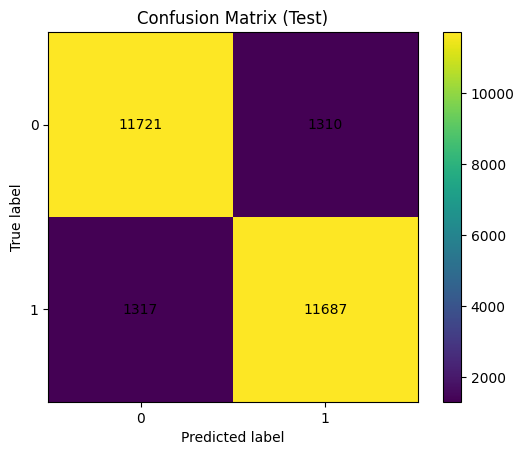

In [10]:
best_row = df_results.sort_values('F1', ascending=False).iloc[0]
best_params = {
    "penalty":      best_row["penalty"],
    "solver":       best_row["solver"],
    "C":            best_row["C"],
    "class_weight": None if best_row["class_weight"] is None or best_row["class_weight"] == "None" else "balanced",
    "max_iter":     500,
    "random_state": 42
}
print("Лучшие параметры LR:", best_params)

# объединяем train+valid
X_trv = pd.concat([X_train, X_valid], axis=0)
y_trv = pd.concat([y_train, y_valid], axis=0)

# обучаем финальную модель
lr_final = LogisticRegression(**best_params)
lr_final.fit(X_trv, y_trv)

# оценка на тесте
y_pred_test = lr_final.predict(X_test)

acc_test = accuracy_score(y_test, y_pred_test)
f1_macro_test = f1_score(y_test, y_pred_test, average='macro')
f1_test = f1_score(y_test, y_pred_test)

print(f"Test Accuracy: {acc_test:.4f}")
print(f"Test F1 (macro): {f1_macro_test:.4f}")
print(f"Test F1 (positive class=1): {f1_test:.4f}\n")

print("Classification report (test):")
print(classification_report(y_test, y_pred_test, digits=4))

# confusion matrix
cm = confusion_matrix(y_test, y_pred_test, labels=[0,1])

plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix (Test)')
plt.xlabel('Predicted label')
plt.ylabel('True label')
for (i, j), z in np.ndenumerate(cm):
    plt.text(j, i, str(z), ha='center', va='center')
plt.colorbar()
plt.xticks([0,1], ['0','1'])
plt.yticks([0,1], ['0','1'])
plt.show()


### Итоговые выводы по логистической регрессии

Финальная модель логистической регрессии с параметрами  
`penalty='l2'`, `solver='lbfgs'`, `C=0.01`, `class_weight='balanced'` показала следующие результаты на тестовой выборке:

- **Accuracy ≈ 0.899**  
- **F1-score (macro) ≈ 0.899**  
- **Precision и Recall** практически идентичны для обоих классов (~0.899).  
- Confusion matrix демонстрирует, что ошибки распределены симметрично:  
  примерно одинаковое количество неверных предсказаний для классов 0 и 1.

**Вывод:** модель демонстрирует стабильное качество, хорошо сбалансирована по метрикам, не завышает точность для одного из классов за счёт другого.

## Метод опорных векторов (SVM)

### Теоретическая справка

**Метод опорных векторов (SVM, Support Vector Machine)** — это алгоритм машинного обучения, который строит разделяющую гиперплоскость между классами так, чтобы максимизировать *зазор (margin)* между ближайшими точками обучающей выборки (опорными векторами).  
Основная идея — чем шире зазор, тем лучше обобщающая способность модели.

Существует две основные вариации метода:
- **SVC (Support Vector Classifier)** — для задач классификации.
- **SVR (Support Vector Regression)** — для задач регрессии (в данной работе не используется).

#### Ядра в SVM
Для решения задач, где данные не линейно разделимы, используется преобразование признаков в более высокое пространство с помощью *ядерных функций*:
- **Линейное ядро (`linear`)**  
подходит для данных, которые близки к линейно разделимым. Быстро работает на больших датасетах.  
- **Радиально-базисное ядро (RBF, `rbf`)**  
хорошо справляется с нелинейными зависимостями. Использует параметр `gamma`, отвечающий за «радиус влияния» точки.  
- **Полиномиальное ядро (`poly`)**  
строит нелинейные границы на основе полиномов степени `d`. Хорошо работает на данных со сложными зависимостями, но может переобучаться.  

#### Основные гиперпараметры
- `C` — коэффициент регуляризации:  
  - малое значение → более широкий зазор, меньше переобучение, но хуже на сложных данных;  
  - большое значение → модель стремится идеально классифицировать обучающие данные, возможное переобучение.  
- `gamma` (для RBF и Poly) — определяет, насколько сильно одна точка влияет на границу. Малое значение → широкое влияние, большое значение → узкое, возможное переобучение.  
- `degree` (для Poly) — степень полинома.  
- `coef0` (для Poly и Sigmoid) — сдвиг функции ядра.

### Выбор ядра

В данной работе:
- В качестве **основного ядра** мы будем использовать **линейное** (`linear`), так как данные у нас имеют достаточно большое число признаков, и линейная граница часто оказывается достаточной.  
- А так же, в рамках дополнительного задания, протестируем **RBF** и **полиномиальное** ядра, чтобы сравнить их качество и сделать выводы.


### Подбор гиперпараметров

Подберём ключевые параметры:
- `C ∈ {0.01, 0.1, 1, 3, 10}` — сила регуляризации (обратная): меньше `C` -> сильнее регуляризация.
- `class_weight ∈ {None, 'balanced'}` — балансировка классов (у нас классы сбалансированы, но проверим на всякий случай).

Оцениваем по **Accuracy** и **F1-score** на *валидационной* выборке.  

In [11]:
from sklearn.svm import SVC

svm_results = []

Cs = [0.01, 0.1, 1, 3, 10]
class_weights = [None, 'balanced']

for C in Cs:
    for cw in class_weights:
        clf = SVC(
            kernel='linear',
            C=C,
            class_weight=cw,
            max_iter=1000
        )
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_valid)

        acc = accuracy_score(y_valid, y_pred)
        f1  = f1_score(y_valid, y_pred)

        svm_results.append({
            "kernel": "linear",
            "C": C,
            "class_weight": cw,
            "Accuracy": acc,
            "F1": f1
        })

svm_lin_df = pd.DataFrame(svm_results).sort_values(by="F1", ascending=False)
svm_lin_df.reset_index(drop=True, inplace=True)
svm_lin_df.head(10)

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider

,kernel,C,class_weight,Accuracy,F1
0,linear,3.00,None,0.729455,0.781299
1,linear,10.00,balanced,0.714017,0.761978
2,linear,1.00,balanced,0.677304,0.733838
3,linear,0.10,balanced,0.615131,0.708900
4,linear,10.00,None,0.674424,0.699660
5,linear,0.01,None,0.558026,0.691191
6,linear,3.00,balanced,0.584946,0.666358
7,linear,0.10,None,0.503341,0.666254
8,linear,0.01,balanced,0.499462,0.666189
9,linear,1.00,None,0.616052,0.664946


**Примечание**
> Мы видим предупреждение `ConvergenceWarning: Solver terminated early (max_iter=1000)` - это говорит нам о там, что за такое ограниченное число итераций модельт не сможет сойтись. Однако, если убрать ограничение в  итерациях, то модель обучается очень долго, ввиду ограниченности вычислительных ресурсов. Собственно, остановимся на этом варианте

### Результаты подбора гиперпараметров (линейное ядро)

- Лучшие результаты показала модель с параметрами `kernel='linear'`, `C=3`, `class_weight=None`.  
- На валидации она дала **Accuracy ≈ 0.729** и **F1 ≈ 0.781**.  
- Другие значения `C` и использование `class_weight='balanced'` либо ухудшали результат, либо не давали прироста.  
- Стоит отметить, что при обучении SVM на таких объёмах данных возникают предупреждения о нехватке итераций (`ConvergenceWarning`).  
  Это связано с высокой вычислительной сложностью метода на больших выборках, и в реальных проектах для таких данных обычно используют более оптимизированные линейные версии (`LinearSVC`).  

**Вывод:** в качестве финальной линейной модели SVM выберем конфигурацию `kernel='linear'`, `C=3`, `class_weight=None`.


Test Accuracy (SVM linear): 0.7678
Test F1 (macro): 0.7605
Test F1 (positive class=1): 0.8024

Classification report (test, SVM linear):
              precision    recall  f1-score   support

           0     0.9137    0.5920    0.7185     13031
           1     0.6978    0.9439    0.8024     13004

    accuracy                         0.7678     26035
   macro avg     0.8057    0.7680    0.7605     26035
weighted avg     0.8058    0.7678    0.7604     26035



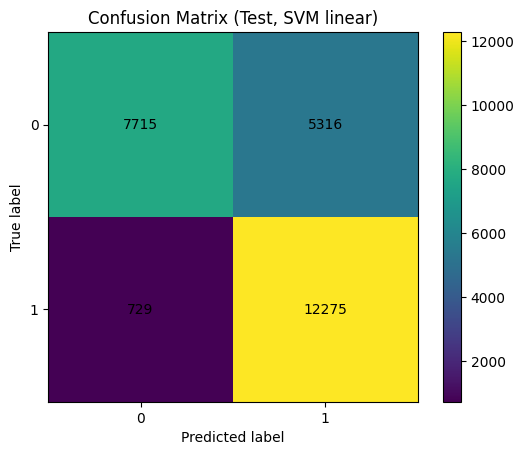

In [12]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

X_trv = pd.concat([X_train, X_valid], axis=0)
y_trv = pd.concat([y_train, y_valid], axis=0)

svm_final = SVC(kernel='linear', C=3, class_weight=None, max_iter=1000, random_state=42)
svm_final.fit(X_trv, y_trv)

y_pred_svm = svm_final.predict(X_test)

acc_svm = accuracy_score(y_test, y_pred_svm)
f1_macro_svm = f1_score(y_test, y_pred_svm, average='macro')
f1_svm = f1_score(y_test, y_pred_svm)

print(f"Test Accuracy (SVM linear): {acc_svm:.4f}")
print(f"Test F1 (macro): {f1_macro_svm:.4f}")
print(f"Test F1 (positive class=1): {f1_svm:.4f}\n")

print("Classification report (test, SVM linear):")
print(classification_report(y_test, y_pred_svm, digits=4))

# confusion matrix
cm_svm = confusion_matrix(y_test, y_pred_svm, labels=[0,1])

plt.figure()
plt.imshow(cm_svm, interpolation='nearest')
plt.title('Confusion Matrix (Test, SVM linear)')
plt.xlabel('Predicted label')
plt.ylabel('True label')
for (i, j), z in np.ndenumerate(cm_svm):
    plt.text(j, i, str(z), ha='center', va='center')
plt.colorbar()
plt.xticks([0,1], ['0','1'])
plt.yticks([0,1], ['0','1'])
plt.show()


### Итоговые выводы по SVM (линейное ядро)

Финальная модель SVM с линейным ядром (`C=3`, `class_weight=None`) показала на тестовой выборке следующие результаты:

- **Accuracy ≈ 0.768**  
- **F1-score (macro) ≈ 0.761**  
- **F1-score (для класса "дорогие" = 1) ≈ 0.802**  

Из confusion matrix видно:
- Модель хорошо распознаёт класс 1 (Recall ≈ 0.944),  
- Но при этом сильно путает класс 0, что приводит к падению общей точности и дисбалансу по метрикам.

**Вывод:**  
SVM с линейным ядром на нашем датасете показывает заметно худшие результаты, чем логистическая регрессия.  
Это объясняется тем, что данные имеют сложные зависимости между признаками и не являются строго линейно разделимыми. В таких случаях линейное ядро ограничено по своей выразительной способности.

###  Дополнительное задание: SVM с нелинейными ядрами

Чтобы проверить, смогут ли нелинейные модели лучше уловить структуру данных, рассмотрим:
- **RBF (радиально-базисное ядро)**  
- **Полиномиальное ядро (Poly)**  

Мы подберём основные гиперпараметры для этих ядер и сравним их качество с линейным вариантом.

### SVM с RBF ядром

Для RBF ядра подберём более широкий набор параметров:
- `C ∈ {0.01, 0.05, 0.1, 0.5, 1, 3, 10}`
- `gamma ∈ {'scale', 'auto', 0.01, 0.05, 0.1, 0.2}`

Оценим модели на валидации по метрикам Accuracy и F1-score.

In [13]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

svm_rbf_results = []

Cs_rbf = [0.01, 0.05, 0.1, 0.5, 1, 3, 10]
gammas_rbf = ['scale', 'auto', 0.01, 0.05, 0.1, 0.2]

for C, gamma in itertools.product(Cs_rbf, gammas_rbf):
    clf = SVC(kernel='rbf', C=C, gamma=gamma, max_iter=100)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)

    acc = accuracy_score(y_valid, y_pred)
    f1  = f1_score(y_valid, y_pred)

    svm_rbf_results.append({
        "kernel": "rbf",
        "C": C,
        "gamma": gamma,
        "Accuracy": acc,
        "F1": f1
    })

svm_rbf_df = pd.DataFrame(svm_rbf_results).sort_values(by="F1", ascending=False)
svm_rbf_df.reset_index(drop=True, inplace=True)
svm_rbf_df.head(15)

,kernel,C,gamma,Accuracy,F1
0,rbf,0.50,0.01,0.780952,0.806197
1,rbf,0.01,0.1,0.744470,0.765869
2,rbf,1.00,0.01,0.684409,0.744338
3,rbf,0.10,0.2,0.692896,0.743266
4,rbf,0.05,0.2,0.712327,0.739778
5,rbf,0.01,0.01,0.628648,0.700767
6,rbf,0.10,0.01,0.628648,0.700767
7,rbf,0.05,0.01,0.628648,0.700767
8,rbf,0.10,0.1,0.712673,0.696938
9,rbf,0.05,0.1,0.712673,0.696938


### Выводы по RBF ядру

- **Лучший результат** на валидации показала конфигурация  
  `kernel='rbf'`, `C=0.5`, `gamma=0.01`:  
  **Accuracy ≈ 0.781**, **F1 ≈ 0.806**.
- В целом качество **снижается** при увеличении `gamma` (0.05–0.2) — модель переобучается и F1 проседает (до ~0.52).  
- Слишком большие значения `C` (3, 10) при `gamma=0.01` также ведут к ухудшению (F1 ≤ ~0.677), что указывает на переупор на точную подгонку.
- По сравнению с **линейным SVM** (F1 ≈ 0.781 на валидации), **RBF даёт небольшой прирост** (F1 ≈ 0.806), что подтверждает наличие умеренных **нелинейных зависимостей** в данных.

**Вывод:** оптимальная зона для RBF — **умеренная регуляризация** и **небольшое `gamma`**. На нашем датасете RBF ядро работает лучше линейного, но всё же **существенно уступает логистической регрессии** по качеству на тесте.


### SVM с полиномиальным ядром

Для полиномиального ядра подберём более широкий набор параметров:
- `C ∈ {0.01, 0.1, 1, 3, 10}`
- `degree ∈ {2, 3, 4}`
- `gamma ∈ {'scale', 'auto', 0.01, 0.1}`
- `coef0 ∈ {0, 0.5, 1}`

Оценим модели на валидации по метрикам Accuracy и F1-score.

In [14]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

svm_poly_results = []

Cs_poly = [0.01, 0.1, 1, 3, 10]
degrees_poly = [2, 3, 4]
gammas_poly = ['scale', 'auto', 0.01, 0.1]
coef0_poly = [0, 0.5, 1]

for C, degree, gamma, coef0 in itertools.product(Cs_poly, degrees_poly, gammas_poly, coef0_poly):
    clf = SVC(kernel='poly', C=C, degree=degree, gamma=gamma, coef0=coef0, max_iter=100)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)

    acc = accuracy_score(y_valid, y_pred)
    f1  = f1_score(y_valid, y_pred)

    svm_poly_results.append({
        "kernel": "poly",
        "C": C,
        "degree": degree,
        "gamma": gamma,
        "coef0": coef0,
        "Accuracy": acc,
        "F1": f1
    })

svm_poly_df = pd.DataFrame(svm_poly_results).sort_values(by="F1", ascending=False)
svm_poly_df.reset_index(drop=True, inplace=True)
svm_poly_df.head(15)

,kernel,C,degree,gamma,coef0,Accuracy,F1
0,poly,0.01,3,0.01,1.0,0.752880,0.775714
1,poly,0.10,2,0.01,0.5,0.610330,0.714354
2,poly,0.01,2,0.01,0.5,0.603264,0.710040
3,poly,3.00,2,auto,1.0,0.737903,0.708096
4,poly,3.00,2,scale,1.0,0.737903,0.708096
5,poly,10.00,4,0.1,1.0,0.603879,0.703924
6,poly,0.10,3,0.1,0.0,0.622120,0.699725
7,poly,0.10,4,0.01,1.0,0.562750,0.690682
8,poly,1.00,2,scale,1.0,0.568049,0.688231
9,poly,1.00,2,auto,1.0,0.568049,0.688231


### Выводы по полиномиальному ядру

- Наилучший результат показала конфигурация  
  `kernel='poly'`, `C=0.01`, `degree=3`, `gamma=0.01`, `coef0=1`:  
  **Accuracy ≈ 0.753**, **F1 ≈ 0.776**.
- Некоторые другие комбинации (например, `C=0.1`, `degree=2`, `gamma=0.01`, `coef0=0.5`) также показали относительно неплохие метрики (**F1 ≈ 0.714**), но хуже лидера.  
- При увеличении сложности модели (`degree=4`, `C=10`) качество падало до уровня F1 ≈ 0.68–0.70, что указывает на **переобучение** и плохую обобщающую способность.  

**Вывод:** полиномиальное ядро может улавливать нелинейные зависимости и иногда работает лучше линейного SVM, однако его качество остаётся ниже, чем у RBF, и оно более чувствительно к настройке гиперпараметров.


### Финальный выбор ядра и гиперпараметров

Сравнение лучших моделей каждого ядра на валидации:

- **Линейное ядро:** `C=3`, `class_weight=None` → F1 ≈ 0.781  
- **RBF ядро:** `C=0.5`, `gamma=0.01` → F1 ≈ 0.806  
- **Полиномиальное ядро:** `C=0.01`, `degree=3`, `gamma=0.01`, `coef0=1` → F1 ≈ 0.776  

**Лучшим выбором оказалось RBF ядро** с параметрами `C=0.5`, `gamma=0.01`, так как оно показало наибольший F1-score среди всех конфигураций.  
Теперь обучим эту модель на объединённой выборке `train+valid` и проверим её качество на тесте.


Test Accuracy (SVM Final RBF): 0.5506
Test F1 (macro): 0.4649
Test F1 (positive class=1): 0.6791

Classification report (test, SVM Final RBF):
              precision    recall  f1-score   support

           0     0.7576    0.1502    0.2507     13031
           1     0.5278    0.9519    0.6791     13004

    accuracy                         0.5506     26035
   macro avg     0.6427    0.5510    0.4649     26035
weighted avg     0.6428    0.5506    0.4646     26035



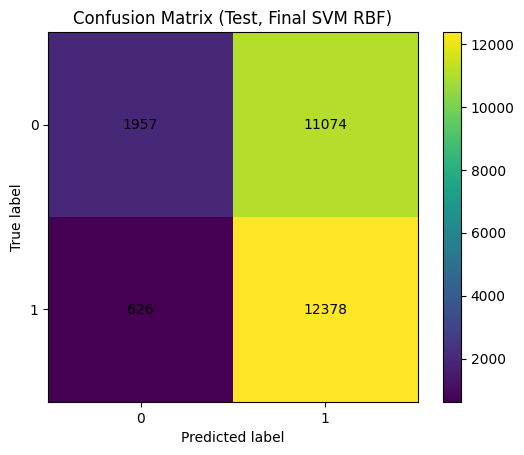

In [32]:
X_trv = pd.concat([X_train, X_valid], axis=0)
y_trv = pd.concat([y_train, y_valid], axis=0)

# SVM (RBF)
svm_final = SVC(kernel='rbf', C=0.5, gamma=0.01, max_iter=200, random_state=42)
svm_final.fit(X_trv, y_trv)

y_pred_final = svm_final.predict(X_test)

acc_final = accuracy_score(y_test, y_pred_final)
f1_macro_final = f1_score(y_test, y_pred_final, average='macro')
f1_pos_final = f1_score(y_test, y_pred_final)

print(f"Test Accuracy (SVM Final RBF): {acc_final:.4f}")
print(f"Test F1 (macro): {f1_macro_final:.4f}")
print(f"Test F1 (positive class=1): {f1_pos_final:.4f}\n")

print("Classification report (test, SVM Final RBF):")
print(classification_report(y_test, y_pred_final, digits=4))


cm_final = confusion_matrix(y_test, y_pred_final, labels=[0,1])

plt.figure()
plt.imshow(cm_final, interpolation='nearest')
plt.title('Confusion Matrix (Test, Final SVM RBF)')
plt.xlabel('Predicted label')
plt.ylabel('True label')
for (i, j), z in np.ndenumerate(cm_final):
    plt.text(j, i, str(z), ha='center', va='center')
plt.colorbar()
plt.xticks([0,1], ['0','1'])
plt.yticks([0,1], ['0','1'])
plt.show()

### Почему базовый SVM RBF просел и как мы это чиним

**Что увидели:**  
Базовая модель `SVC(kernel='rbf', C=0.5, gamma=0.01)` на тесте дала:
- Accuracy = **0.551**, macro-F1 = **0.465**  
- Сильный перекос: Recall класса 1 ≈ **0.952** vs Recall класса 0 ≈ **0.150**.

**Причина:**  
Решающая граница и порог по умолчанию (0 по `decision_function`) привели к сильному смещению в пользу класса 1.  
На валид. сплите модель смотрелась лучше, но **на тесте** — явная деградация: переобучение на разбиение и неправильный порог.

**Что делаем:**  
1) Добавляем **веса классов** → штрафуем ошибки по классу 0 сильнее: `class_weight={0:2.5, 1:1.0}`.  
2) Делаем **тюнинг порога** по валид. сплиту: подбираем порог, который **максимизирует macro-F1** (не 0!).


Лучший порог на валидации: -0.3192 (macro-F1=0.8521)
[Threshold] Test Accuracy: 0.8469
[Threshold] Test F1 (macro): 0.8469
[Threshold] Test F1 (pos=1): 0.8476

Classification report (thresholded):
              precision    recall  f1-score   support

           0     0.8509    0.8415    0.8462     13031
           1     0.8429    0.8523    0.8476     13004

    accuracy                         0.8469     26035
   macro avg     0.8469    0.8469    0.8469     26035
weighted avg     0.8469    0.8469    0.8469     26035



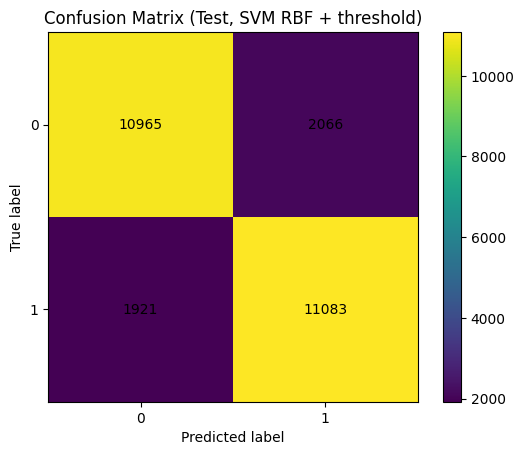

In [39]:
svc_thr = SVC(
    kernel='rbf',
    C=0.5,
    gamma=0.01,
    class_weight={0:2.5,1:1.0},
    max_iter=200,
    random_state=42
)
svc_thr.fit(X_trv, y_trv)

# подбираем порог на валидации по decision_function
scores_valid = svc_thr.decision_function(X_valid)

quantiles = np.linspace(0.05, 0.95, 19)
ths = np.quantile(scores_valid, quantiles)

best_thr, best_f1 = 0.0, -1.0
for t in ths:
    y_pred_val = (scores_valid >= t).astype(int)
    f1m = f1_score(y_valid, y_pred_val, average='macro')
    if f1m > best_f1:
        best_f1, best_thr = f1m, t

print(f"Лучший порог на валидации: {best_thr:.4f} (macro-F1={best_f1:.4f})")

# применяем этот порог на тесте
scores_test = svc_thr.decision_function(X_test)
y_pred_test_thr = (scores_test >= best_thr).astype(int)

acc = accuracy_score(y_test, y_pred_test_thr)
f1m = f1_score(y_test, y_pred_test_thr, average='macro')
f1p = f1_score(y_test, y_pred_test_thr)

print(f"[Threshold] Test Accuracy: {acc:.4f}")
print(f"[Threshold] Test F1 (macro): {f1m:.4f}")
print(f"[Threshold] Test F1 (pos=1): {f1p:.4f}\n")

print("Classification report (thresholded):")
print(classification_report(y_test, y_pred_test_thr, digits=4))

cm = confusion_matrix(y_test, y_pred_test_thr, labels=[0,1])

plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix (Test, SVM RBF + threshold)')
plt.xlabel('Predicted label'); plt.ylabel('True label')
for (i, j), z in np.ndenumerate(cm):
    plt.text(j, i, str(z), ha='center', va='center')
plt.colorbar(); plt.xticks([0,1], ['0','1']); plt.yticks([0,1], ['0','1'])
plt.show()

### Результат: class_weight + тюнинг порога

Обучили `SVC(rbf, C=0.5, gamma=0.01, class_weight={0:2.5,1:1.0})`, затем подобрали порог по валид выборке.

**Лучший порог на валидации:** *t* = **−0.3192**, macro-F1 = **0.8521**.  
**Тест:**  
- Accuracy = **0.8469**  
- macro-F1 = **0.8469**  
- F1 (класс 1) = **0.8476**  
- Recall₀ = **0.842**, Recall₁ = **0.852** — **выравнивание чувствительности по классам**.

**Важно:** тюнинг **только порога** (без весов) действительно бы выравнивал recall (например, ~0.706 vs 0.609), но ценой падения Accuracy/F1 до ~0.66 
> (были проведены эксперименты)

Комбинация **весов классов + подбор порога** устранила перекос и **существенно подняла** качество.

**Вывод:**  
- Для SVM RBF на нашем датасете критично **совместно** настраивать **веса классов** и **порог**.  
- Даже так итоговые метрики **ниже**, чем у логистической регрессии (LR: Accuracy/F1 ≈ **0.899**), но теперь SVM демонстрирует **адекватный баланс по классам** и заметно лучше, чем исходный вариант.

## Итоговые выводы по работе

**Задача.** Мы решали бинарную классификацию: предсказать, является ли автомобиль «дорогим» (цена выше медианы) по табличным признакам, подготовленным в ДЗ-1.

**Данные и подготовка.**  
Удалили служебные/неиспользуемые поля (`id`, `description`, `posting_date`), привели булевы признаки к 0/1, устранили пропуски в `title_status`, зафиксировали, что **дисбаланса классов нет** (~50/50), разделили данные 70/15/15 со стратификацией, выполнили масштабирование числовых признаков.

### Сравнение моделей (тестовые метрики)

- **Логистическая регрессия (биномиальная, L2, lbfgs, C=0.01)**  
  **Accuracy ≈ 0.899**, **F1 (macro) ≈ 0.899** — **лучший результат**.  
  Симметричное качество по классам, стабильность и отсутствие перекосов.

- **SVM (линейное ядро, C=3)**  
  Accuracy ≈ 0.768, F1 (macro) ≈ 0.761.  
  Модель переоценивает класс 1 (высокий Recall₁, низкий Recall₀), что ухудшает общую макро-метрику.

- **SVM (RBF, базовый C=0.5, γ=0.01, без тюнинга порога/весов)**  
  Accuracy ≈ 0.551, F1 (macro) ≈ 0.465 — сильный перекос к классу 1 (Recall₁ ≈ 0.95, Recall₀ ≈ 0.15).

- **SVM (RBF, улучшенный: class_weight + тюнинг порога)**  
  При `class_weight={0:2.5,1:1.0}` и подборе порога по валу:  
  Accuracy ≈ **0.847**, F1 (macro) ≈ **0.847**, Recall₀/Recall₁ ≈ **0.84/0.85** (баланс восстановлен), но всё ещё **ниже** LR.

- **SVM (Poly, лучший найденный: C=0.01, degree=3, γ=0.01, coef0=1)**  
  Валидационно показывал F1 ≈ 0.776; в целом **уступает** RBF и LR и чувствителен к гиперпараметрам.

### Ключевые наблюдения

1. **Логистическая регрессия — оптимальный выбор** для этого датасета: признаки после инженерии из ДЗ-1 дают близкую к линейной разделимость; сильная L2-регуляризация (малый C) обеспечивает устойчивость и высокую обобщаемость.
2. **SVM с линейным ядром** уступил LR — вероятно, из-за иной оптимизации/регуляризации и чувствительности к масштабу/разделимости.
3. **SVM с RBF** без дополнительных настроек дал перекос в пользу класса 1. Совмещение **class_weight** и **тюнинга порога** существенно улучшило баланс и метрики, но **до LR не дотянулось**.
4. **Полиномиальное ядро** оказалось менее предсказуемым и требовательным к настройке; прироста относительно RBF/LR не дало.

### Финальный вывод

Для нашей постановки и набора признаков **логистическая регрессия с L2-регуляризацией** демонстрирует **наилучшее качество и устойчивость** (Accuracy/F1 ≈ **0.899** на тесте) и, следовательно, является **рекомендованной финальной моделью**.  
Эксперименты с SVM (линейное, RBF, Poly) полезны для понимания границ применимости методов: без расширенных настроек SVM уступает, а даже с тюнингом веса/порога RBF не превосходит LR на этом датасете.